<a href="https://colab.research.google.com/github/kniemi641/UC-MScA/blob/master/ML%20Homework%205%20-%20Boosting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Homework 5 - Support Vector Machines
The purpose of this exercise is to compare the performance of support-vector machine models (svms) generated using the default sklearn hyper-parameters, and hyper-parameters tuned using the sklearn GridSearchCV method. 

## Packages & Variables

In [0]:
import pandas as pd
import numpy as np
import math
import os
from scipy import stats

from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC, LinearSVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, auc
from sklearn.ensemble import RandomForestClassifier

#Plotting Packages
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
import seaborn as sns

#Utility stuff
import warnings
warnings.filterwarnings('ignore')
from google.colab import drive, files
drive.mount('/content/gdrive')

#Go Isoto
np.random.seed(235)

In [0]:
#GLOBAL & CONSTANTS
HW_NUM = 5
INPUT_DATA_FILE_TRAIN = 'train_data.csv'
INPUT_DATA_FILE_TEST = 'test_data.csv'

# static
GD_CODE_DIR = '/content/gdrive/My Drive/Code/uchicago/'
SUBJECT_DIR = 'Machine Learning & Predictive Analytics/'
DATA_DIR = 'data/'
MODEL_DIR = 'models/'
LOGS_DIR = 'logs/'
HOMEWORK_DIR = 'Homework {}/'.format(HW_NUM)
NOTEBOOK_NAME = 'Homework {}.ipynb'.format(HW_NUM)


MAIN_PATH = os.path.join(GD_CODE_DIR
                        ,SUBJECT_DIR
                        ,HOMEWORK_DIR)

TEST_INPUT_FILE = os.path.join(MAIN_PATH
                          ,DATA_DIR
                          ,INPUT_DATA_FILE_TEST)

TRAIN_INPUT_FILE = os.path.join(MAIN_PATH
                          ,DATA_DIR
                          ,INPUT_DATA_FILE_TRAIN)


NOTEBOOK_FILE = os.path.join(MAIN_PATH
                            ,NOTEBOOK_NAME)

MODEL_EXPORT_PATH = os.path.join(MAIN_PATH
                                ,MODEL_DIR)

LOG_PATH = os.path.join(MAIN_PATH
                       ,LOGS_DIR)

## Data Exploration & Preperation

First the train and test data is loaded from the .csv files provided. The categorical variable 'class' is the response and the rest of the variables are used as predictors.  Observations with NaN values are dropped. The data has been provided in 2 files corresponding to the train and test set to be used for this exercise. 

In [3]:
train_df = pd.DataFrame(pd.read_csv(TRAIN_INPUT_FILE))
test_df = pd.DataFrame(pd.read_csv(TEST_INPUT_FILE))

train_df.replace(["NaN", 'NaT'], np.nan, inplace = True)
train_df.dropna(how='any', axis = 0, inplace=True)

test_df.replace(["NaN", 'NaT'], np.nan, inplace = True)
test_df.dropna(how='any', axis = 0, inplace = True)

X_train = train_df.loc[:, train_df.columns != 'class']
y_train = train_df.loc[:, train_df.columns == 'class'].values.ravel()

X_test = test_df.loc[:, test_df.columns != 'class']
y_test = test_df.loc[:, test_df.columns == 'class'].values.ravel()

predictors = train_df.columns
print(predictors.values)

print('\nShape of X Train: {}'.format(X_train.shape))
print('\nShape of X Test: {}'.format(X_test.shape))
print('\nShape of y Train: {}'.format(y_train.shape))
print('\nShape of y Test: {}'.format(y_test.shape))

['class' 'BrdIndx' 'Area' 'Round' 'Bright' 'Compact' 'ShpIndx' 'Mean_G'
 'Mean_R' 'Mean_NIR' 'SD_G' 'SD_R' 'SD_NIR' 'LW' 'GLCM1' 'Rect' 'GLCM2'
 'Dens' 'Assym' 'NDVI' 'BordLngth' 'GLCM3' 'BrdIndx_40' 'Area_40'
 'Round_40' 'Bright_40' 'Compact_40' 'ShpIndx_40' 'Mean_G_40' 'Mean_R_40'
 'Mean_NIR_40' 'SD_G_40' 'SD_R_40' 'SD_NIR_40' 'LW_40' 'GLCM1_40'
 'Rect_40' 'GLCM2_40' 'Dens_40' 'Assym_40' 'NDVI_40' 'BordLngth_40'
 'GLCM3_40' 'BrdIndx_60' 'Area_60' 'Round_60' 'Bright_60' 'Compact_60'
 'ShpIndx_60' 'Mean_G_60' 'Mean_R_60' 'Mean_NIR_60' 'SD_G_60' 'SD_R_60'
 'SD_NIR_60' 'LW_60' 'GLCM1_60' 'Rect_60' 'GLCM2_60' 'Dens_60' 'Assym_60'
 'NDVI_60' 'BordLngth_60' 'GLCM3_60' 'BrdIndx_80' 'Area_80' 'Round_80'
 'Bright_80' 'Compact_80' 'ShpIndx_80' 'Mean_G_80' 'Mean_R_80'
 'Mean_NIR_80' 'SD_G_80' 'SD_R_80' 'SD_NIR_80' 'LW_80' 'GLCM1_80'
 'Rect_80' 'GLCM2_80' 'Dens_80' 'Assym_80' 'NDVI_80' 'BordLngth_80'
 'GLCM3_80' 'BrdIndx_100' 'Area_100' 'Round_100' 'Bright_100'
 'Compact_100' 'ShpIndx_100' 'Mean_

Next the train and test predictors are scaled using the training data scale parameters.

In [0]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Random Forest

Next a random forest classifier is trained using the default parameters from sklearn and used to predict the test data. This model will be a baseline to benchmark the svm models.

In [0]:
rnd_clf = RandomForestClassifier()
rnd_clf.fit(X_train_scaled, y_train)

yhat_rf_train = rnd_clf.predict(X_train_scaled)
yhat_rf_train_prob = rnd_clf.predict_proba(X_train)

yhat_rf_test = rnd_clf.predict(X_test_scaled)
yhat_rf_test_prob = rnd_clf.predict_proba(X_test)

The model score, confusion matrix and classification report are shown below.

In [6]:
rnd_clf_score_train = rnd_clf.score(X_train_scaled, y_train)

rnd_clf_score = rnd_clf.score(X_test_scaled, y_test)
rnd_clf_conf_mx = (confusion_matrix(y_test, yhat_rf_test))
rnd_clf_class_report = (classification_report(y_test, yhat_rf_test))

print('Model Score (train): {}'.format(round(rnd_clf_score_train, 4)))
print('Model Score (test): {}'.format(round(rnd_clf_score, 4)))
print('\nConfusion Matrix\n{}\n'.format(rnd_clf_conf_mx))
print('\nClassification Report\n{}'.format(rnd_clf_class_report))

Model Score (train): 0.9901
Model Score (test): 0.7857

Confusion Matrix
[[14  0  0  0  0  0  0  0  0]
 [ 2 21  0  2  0  0  0  0  0]
 [ 1  1 13  0  0  0  0  0  0]
 [ 0  4  0 19  0  0  0  0  0]
 [ 0  0  0  0 23  0  0  0  6]
 [ 1  2  0  0  0 12  0  0  0]
 [ 3  0  0  0  0  0 13  0  0]
 [ 0  1  0  7  3  0  0  3  0]
 [ 0  0  0  1  2  0  0  0 14]]


Classification Report
              precision    recall  f1-score   support

    asphalt        0.67      1.00      0.80        14
   building        0.72      0.84      0.78        25
        car        1.00      0.87      0.93        15
   concrete        0.66      0.83      0.73        23
      grass        0.82      0.79      0.81        29
       pool        1.00      0.80      0.89        15
     shadow        1.00      0.81      0.90        16
       soil        1.00      0.21      0.35        14
       tree        0.70      0.82      0.76        17

   micro avg       0.79      0.79      0.79       168
   macro avg       0.84      0.78   

The model seems to be overfit, the performance on the train data is near perfect and there is a significant drop in performance on the test data.

The feature importance plot below shows that even the top predictors don't capture that much variance.

Top 10 Feature ranking:
1 Predictor Mean_G 0.0445
2 Predictor Round 0.0255
3 Predictor Mean_R 0.0201
4 Predictor ShpIndx 0.0121
5 Predictor Bright 0.0014
6 Predictor BrdIndx 0.0011
7 Predictor Area 0.0009
8 Predictor Compact 0.0006
9 Predictor class 0.0006
10 Predictor Mean_NIR 0.0002


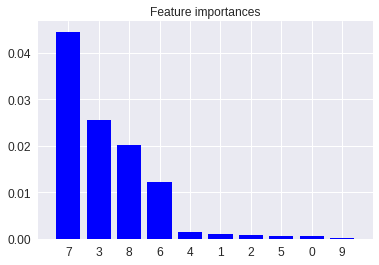

In [7]:
def get_top_importances(model, predictors, n=5):
  importances = model.feature_importances_[:n]
  indices = np.argsort(importances)[::-1]

  # Print the feature ranking
  print("Top {} Feature ranking:".format(n))

  for f in range(n):
      print("{} Predictor {} {}".format((f + 1), predictors[indices[f]], round(importances[indices[f]], 4)))

  # Plot the feature importances of the forest
  plt.figure()
  plt.title("Feature importances")
  plt.bar(range(n), importances[indices[:n]],
         color="b", align="center")
  plt.xticks(range(10), indices)
  plt.xlim([-1, n])
  plt.show()
  
get_top_importances(rnd_clf, predictors, 10)

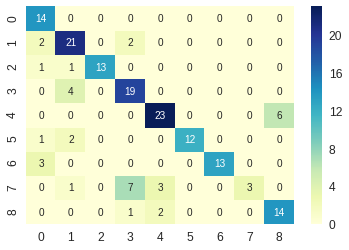

In [8]:
def make_heat_map(matrix):
    sns.heatmap(matrix
               , annot=True
               , annot_kws={"Size" : 10}
               , cmap="YlGnBu")
    
    plt.figure(figsize=(10,10))
    
    plt.show()
    
make_heat_map(rnd_clf_conf_mx)

## Linear SVM

Next a support vector classifier is trained using the default sklearn parameters and used to predict the train and test values. The default kernel for the SVC method is 'linear'.

In [0]:
linear_svm = SVC()
linear_svm.fit(X_train_scaled, y_train) 

yhat_linear_svm_train = linear_svm.predict(X_train_scaled)
yhat_linear_svm_test = linear_svm.predict(X_test_scaled)

The model score, confusion matrix, and classification report are shown below.

In [11]:
linear_svm_score_train = linear_svm.score(X_train_scaled, y_train)
linear_svm_score = linear_svm.score(X_test_scaled, y_test)
linear_svm_conf_mx = (confusion_matrix(y_test, yhat_linear_svm_test))
linear_svm_class_report = (classification_report(y_test, yhat_linear_svm_test))

print('Model Score (Train): {}'.format(round(linear_svm_score_train,4)))
print('Model Score (Test): {}'.format(round(linear_svm_score, 4)))
print('\nConfusion Matrix\n',linear_svm_conf_mx)
print('\nClassification Report\n',linear_svm_class_report)

Model Score (Train): 0.9152
Model Score (Test): 0.8214

Confusion Matrix
 [[13  0  0  0  0  0  1  0  0]
 [ 1 21  0  2  1  0  0  0  0]
 [ 0  2 13  0  0  0  0  0  0]
 [ 0  4  0 19  0  0  0  0  0]
 [ 0  1  0  0 26  0  0  0  2]
 [ 0  1  0  0  0 13  1  0  0]
 [ 1  0  0  0  0  0 15  0  0]
 [ 0  2  0  5  3  0  0  4  0]
 [ 0  0  0  1  2  0  0  0 14]]

Classification Report
               precision    recall  f1-score   support

    asphalt        0.87      0.93      0.90        14
   building        0.68      0.84      0.75        25
        car        1.00      0.87      0.93        15
   concrete        0.70      0.83      0.76        23
      grass        0.81      0.90      0.85        29
       pool        1.00      0.87      0.93        15
     shadow        0.88      0.94      0.91        16
       soil        1.00      0.29      0.44        14
       tree        0.88      0.82      0.85        17

   micro avg       0.82      0.82      0.82       168
   macro avg       0.87      0.81  

This model also appears to be overfit, however much less so than the random forest. 

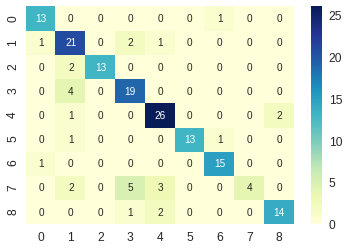

In [12]:
make_heat_map(linear_svm_conf_mx)

## Linear SVM with GridSearchCV

Next the linear svm model hyper-parameters are tuned using the grid search cross validation method, using a 9-fold validation. The parameter *'C'* in sklearn represents the error penalty, where a larger values of C represents a smaller hyper-plane margin. Ideally, there should be a large margin between the support vectors, however if the limit is too strict the model will miss some potential information

The best estimator output from the grid search object represents the the model with a *'C'* value which has the best performance on a cross validated set. 

In [21]:
#create a dictionary of parameters 
c = np.concatenate([np.arange(0.001, .1, .005)
                   , np.arange(.01, 1, .05)
                   , np.arange(1, 10, .5)])

param_grid_1 = {'C':c
                ,'random_state':[235]}

# create support vector classifier using linear kernal
linear_svm_obj=SVC(kernel = 'linear')

# Create gridsearch object with various combinations of parameters
linear_svm_Grid = GridSearchCV(linear_svm_obj
                               , param_grid_1
                               , cv = 9
                               , refit = True
                               , n_jobs=-1
                               , verbose = 1)

linear_svm_Grid.fit(X_train_scaled, y_train);

Fitting 9 folds for each of 58 candidates, totalling 522 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 172 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 522 out of 522 | elapsed:   19.8s finished


The best estimator from the grid search is saved, which has the hyper-parameters (only *C* for this model) shown below.

In [22]:
linear_svm_best_estimator = linear_svm_Grid.best_estimator_
linear_svm_best_params = linear_svm_Grid.best_params_
print(linear_svm_best_params)

yhat_linear_svm_grid_train = linear_svm_best_estimator.predict(X_train_scaled)
yhat_linear_svm_grid = linear_svm_best_estimator.predict(X_test_scaled)

{'C': 0.036000000000000004, 'random_state': 235}


In [23]:
linear_svm_grid_score_train = linear_svm_best_estimator.score(X_train_scaled, y_train)
linear_svm_grid_score = linear_svm_best_estimator.score(X_test_scaled, y_test)
linear_svm_grid_conf_mx = confusion_matrix(y_test, yhat_linear_svm_grid)
linear_svm_grid_class_report = classification_report(y_test, yhat_linear_svm_grid)

print('Model Score (train): {}'.format(round(linear_svm_grid_score_train,4)))
print('Model Score (test): {}'.format(round(linear_svm_grid_score, 4)))
print('\nConfusion Matrix\n',linear_svm_grid_conf_mx)
print('\nClassification Report\n',linear_svm_grid_class_report)

Model Score (train): 0.931
Model Score (test): 0.8393

Confusion Matrix
 [[12  0  0  0  0  0  2  0  0]
 [ 0 23  0  2  0  0  0  0  0]
 [ 0  1 14  0  0  0  0  0  0]
 [ 0  3  0 19  0  0  0  1  0]
 [ 0  0  0  0 24  0  0  1  4]
 [ 1  0  0  0  0 14  0  0  0]
 [ 1  0  0  0  0  0 15  0  0]
 [ 0  1  0  6  2  0  0  5  0]
 [ 0  0  0  1  1  0  0  0 15]]

Classification Report
               precision    recall  f1-score   support

    asphalt        0.86      0.86      0.86        14
   building        0.82      0.92      0.87        25
        car        1.00      0.93      0.97        15
   concrete        0.68      0.83      0.75        23
      grass        0.89      0.83      0.86        29
       pool        1.00      0.93      0.97        15
     shadow        0.88      0.94      0.91        16
       soil        0.71      0.36      0.48        14
       tree        0.79      0.88      0.83        17

   micro avg       0.84      0.84      0.84       168
   macro avg       0.85      0.83   

The model using the tuned hyper-parameters does indeed perform better than the model using default parameters. It has a higher train score and the test score has also improved. However there is still some overfitting.

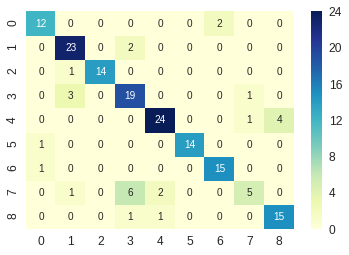

In [24]:
make_heat_map(linear_svm_grid_conf_mx)

## Polynomial SVM with GridSearchCV
Next the grid search method is applied to an svc using a polynomial kernal, where the degree of the polynomial is iterated over; along with *'C'*.

In [31]:
#create a dictionary of parameters 
param_grid_2 = { 'C':c
               , 'degree': [1/2,2,3,4]
               , 'random_state':[235]}

# create Random Forest model 
poly_svm_obj=SVC(kernel = 'poly')

# Create gridsearch object with various combinations of parameters
poly_svm_Grid = GridSearchCV(poly_svm_obj
                             , param_grid_2
                             , cv = 9
                             , refit = True
                             , n_jobs=-1
                             , verbose = 1)

poly_svm_Grid.fit(X_train_scaled, y_train)

Fitting 9 folds for each of 232 candidates, totalling 2088 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:   16.5s
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:   35.9s
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 1246 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 1796 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 2088 out of 2088 | elapsed:  2.5min finished


GridSearchCV(cv=9, error_score='raise-deprecating',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='poly', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'C': array([1.0e-03, 6.0e-03, 1.1e-02, 1.6e-02, 2.1e-02, 2.6e-02, 3.1e-02,
       3.6e-02, 4.1e-02, 4.6e-02, 5.1e-02, 5.6e-02, 6.1e-02, 6.6e-02,
       7.1e-02, 7.6e-02, 8.1e-02, 8.6e-02, 9.1e-02, 9.6e-02, 1.0e-02,
       6.0e-02, 1.1e-01, 1.6e-01, 2.1e-01, 2.6e-01, 3.1e-01, 3.6e-01,
   ...5e+00, 8.0e+00, 8.5e+00,
       9.0e+00, 9.5e+00]), 'degree': [0.5, 2, 3, 4], 'random_state': [235]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

The best estimator is saved and the hyper-parameters for it are shown below. 

In [32]:
poly_svm_best_estimator = poly_svm_Grid.best_estimator_
poly_svm_best_params = poly_svm_Grid.best_params_
print(poly_svm_best_params)
yhat_poly_svm_train = poly_svm_best_estimator.predict(X_train_scaled)
yhat_poly_svm = poly_svm_best_estimator.predict(X_test_scaled)

{'C': 4.5, 'degree': 2, 'random_state': 235}


The C value this time is much larger and uses a third degree polynomial.

In [33]:
poly_svm_grid_score_train = poly_svm_best_estimator.score(X_train_scaled, y_train)
poly_svm_grid_score = poly_svm_best_estimator.score(X_test_scaled, y_test)
poly_svm_conf_mx = confusion_matrix(y_test, yhat_poly_svm)
poly_svm_class_report = classification_report(y_test, yhat_poly_svm)

print('Model Score (train): {}'.format(round(poly_svm_grid_score_train,4)))
print('Model Score (test): {}'.format(round(poly_svm_grid_score, 4)))
print('\nConfusion Matrix\n',poly_svm_conf_mx)
print('\nClassification Report\n',poly_svm_class_report)

Model Score (train): 0.9684
Model Score (test): 0.7798

Confusion Matrix
 [[13  0  0  0  0  0  1  0  0]
 [ 0 20  0  2  2  0  0  0  1]
 [ 0  2 13  0  0  0  0  0  0]
 [ 0  5  0 17  1  0  0  0  0]
 [ 0  0  0  0 24  0  0  2  3]
 [ 0  0  0  1  0 14  0  0  0]
 [ 2  0  0  0  0  0 14  0  0]
 [ 0  1  0  6  4  0  0  3  0]
 [ 0  0  0  1  3  0  0  0 13]]

Classification Report
               precision    recall  f1-score   support

    asphalt        0.87      0.93      0.90        14
   building        0.71      0.80      0.75        25
        car        1.00      0.87      0.93        15
   concrete        0.63      0.74      0.68        23
      grass        0.71      0.83      0.76        29
       pool        1.00      0.93      0.97        15
     shadow        0.93      0.88      0.90        16
       soil        0.60      0.21      0.32        14
       tree        0.76      0.76      0.76        17

   micro avg       0.78      0.78      0.78       168
   macro avg       0.80      0.77  

This model actually performs much worse than the linear kernal on both the train and test set. The f1-score, which represents a weighted average of the precision and recall. So overall much worse performance

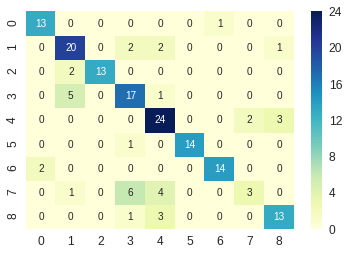

In [34]:
make_heat_map(poly_svm_conf_mx)

## RBF SVM with GridSearch
Finally an svm model using a radial basis kernal, which represents the squared euclidean distance between the two feature vectors, is tuned on the gamma parameter.

In [36]:
# create a dictionary of parameters 
param_grid_3 = { 'C':c
               , 'gamma': [0.001, 0.01, 0.1, 1, 10, 100]
               , 'random_state':[0]}

# create Random Forest model 
svm_rbf_obj=SVC(kernel = 'rbf')

# Create gridsearch object with various combinations of parameters
rbf_svm_Grid = GridSearchCV(svm_rbf_obj
                            , param_grid_3
                            , cv = 9
                            , refit = True
                            , n_jobs=-1
                            , verbose = 1)

rbf_svm_Grid.fit(X_train_scaled, y_train)

Fitting 9 folds for each of 348 candidates, totalling 3132 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:   19.3s
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:   43.4s
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 1246 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 1796 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 2446 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 3132 out of 3132 | elapsed:  4.9min finished


GridSearchCV(cv=9, error_score='raise-deprecating',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'C': array([1.0e-03, 6.0e-03, 1.1e-02, 1.6e-02, 2.1e-02, 2.6e-02, 3.1e-02,
       3.6e-02, 4.1e-02, 4.6e-02, 5.1e-02, 5.6e-02, 6.1e-02, 6.6e-02,
       7.1e-02, 7.6e-02, 8.1e-02, 8.6e-02, 9.1e-02, 9.6e-02, 1.0e-02,
       6.0e-02, 1.1e-01, 1.6e-01, 2.1e-01, 2.6e-01, 3.1e-01, 3.6e-01,
   ...0, 8.5e+00,
       9.0e+00, 9.5e+00]), 'gamma': [0.001, 0.01, 0.1, 1, 10, 100], 'random_state': [0]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [37]:
rbf_svm_best_estimator = rbf_svm_Grid.best_estimator_
rbf_svm_best_params = rbf_svm_Grid.best_params_
print(rbf_svm_best_params)

y_pred_poly_rbf_grid_train = rbf_svm_best_estimator.predict(X_train_scaled)
y_pred_poly_rbf_grid = rbf_svm_best_estimator.predict(X_test_scaled)

{'C': 2.0, 'gamma': 0.01, 'random_state': 0}


In [38]:
rbf_svm_grid_score_train = poly_svm_best_estimator.score(X_train_scaled, y_train)
rbf_svm_grid_score = poly_svm_best_estimator.score(X_test_scaled, y_test)
rbf_svm_conf_mx = confusion_matrix(y_test, yhat_poly_svm)
rbf_svm_class_report = classification_report(y_test, yhat_poly_svm)

print('Model Score (train): {}'.format(round(rbf_svm_grid_score_train,4)))
print('Model Score (test): {}'.format(round(rbf_svm_grid_score, 4)))
print('\nConfusion Matrix\n',rbf_svm_conf_mx)
print('\nClassification Report\n',rbf_svm_class_report)

Model Score (train): 0.9684
Model Score (test): 0.7798

Confusion Matrix
 [[13  0  0  0  0  0  1  0  0]
 [ 0 20  0  2  2  0  0  0  1]
 [ 0  2 13  0  0  0  0  0  0]
 [ 0  5  0 17  1  0  0  0  0]
 [ 0  0  0  0 24  0  0  2  3]
 [ 0  0  0  1  0 14  0  0  0]
 [ 2  0  0  0  0  0 14  0  0]
 [ 0  1  0  6  4  0  0  3  0]
 [ 0  0  0  1  3  0  0  0 13]]

Classification Report
               precision    recall  f1-score   support

    asphalt        0.87      0.93      0.90        14
   building        0.71      0.80      0.75        25
        car        1.00      0.87      0.93        15
   concrete        0.63      0.74      0.68        23
      grass        0.71      0.83      0.76        29
       pool        1.00      0.93      0.97        15
     shadow        0.93      0.88      0.90        16
       soil        0.60      0.21      0.32        14
       tree        0.76      0.76      0.76        17

   micro avg       0.78      0.78      0.78       168
   macro avg       0.80      0.77  

This method again appears to produce an overfit model. The performance on train is near perfect, however the test predictions are near the upper end of results on test data.

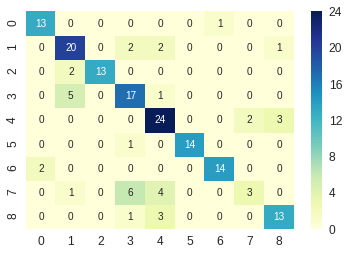

In [39]:
make_heat_map(rbf_svm_conf_mx)

## Analysis

Based on the classification reports, which give the precision, recall & f1-score for each class, the models using svm gridsearch for the linear & rbf kernal perform best, but only slightly better than the default sklearn svm and random forest models and parameters. I do think using grid search adds value to the models here, however using kernals beyond linear do not seem to add value in this circumstance. You may capture some vecotr in these more complicated feature spaces generted by these kernals, but it does take additional time and there is definitely a real risk of overfitting. In fact all of these models would qualify as overfitting in this case, although there is some differene in the amount. Overall I think think the linear svm using grid search is the best method for this approach, it has the least difference between its train and test performance, compared to the rbf kernal which has a near %100 training performance. That is a definite sign of extreme overfitting

In [0]:
!jupyter nbconvert --to html '/content/gdrive/My Drive/Code/Machine Learning & Predictive Analytics/Homework 5/Homework 5.ipynb';